# Importing the libraries

In [123]:
import pandas as pd
import numpy as np
import os

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# Importing the data

In [9]:
jan = pd.read_parquet('data/yellow_tripdata_2022-01.parquet')
feb = pd.read_parquet('data/yellow_tripdata_2022-02.parquet')

# Questions


## Q1. Downloading the data
Read the data for January. How many columns are there?

Answer: There are 19 columns.

In [15]:
len(jan.columns.to_list())

19

## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

Answer: 46.45 min²

In [30]:
# Calculating the trip duration
jan['trip_duration'] = jan['tpep_dropoff_datetime']-jan['tpep_pickup_datetime']

In [31]:
# Rounding the minutes elapsed for each trip
jan['trip_duration'] = jan['trip_duration'].apply(lambda td: round(td.total_seconds()/60))

In [39]:
# Calculating the standard deviation for January trips
jan_std = round(np.std(jan['trip_duration'].values), 2)
print(jan_std)

46.45


## Q3. Dropping outliers
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

Answer: 98% of the data.

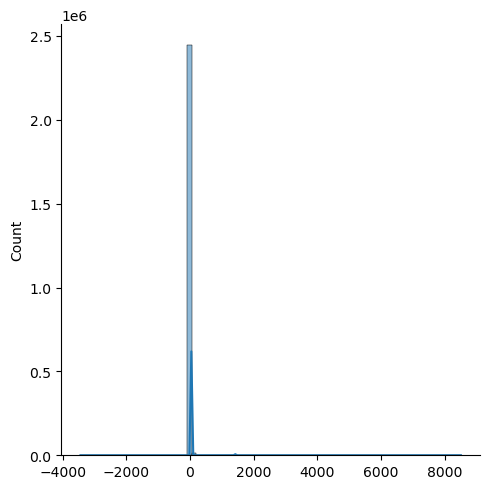

In [62]:
import seaborn as sns
sns.displot(jan['trip_duration'].values, bins=82, kde=True);

In [63]:
jan['trip_duration'].describe()

count    2.463931e+06
mean     1.421117e+01
std      4.644668e+01
min     -3.442000e+03
25%      6.000000e+00
50%      1.000000e+01
75%      1.600000e+01
max      8.513000e+03
Name: trip_duration, dtype: float64

In [67]:
jan.agg(
    {
        "trip_duration" : ["min", "max", "median", "mean", "std"]
    }
)

,trip_duration
min,-3442.000000
max,8513.000000
median,10.000000
mean,14.211170
std,46.446679


In [75]:
jan_shape_before = jan.shape

(2463931, 20)

In [76]:
# Removing the outliers

jan = jan.loc[(jan['trip_duration']>1) & (jan['trip_duration']<60)]

In [77]:
jan_shape_after = jan.shape

(2410474, 20)

In [ ]:
print(f"{round((jan_shape_after/jan_shape_before)*100)}% of data stayed.")

In [94]:
print(f"{round((2410474/2463931)*100)}% of data stayed.")

98% of data stayed.


## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

    Turn the dataframe into a list of dictionaries
    Fit a dictionary vectorizer
    Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

Answer: 515 columns.

In [132]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [134]:
jan[categorical] = jan[categorical].astype(str)

C:\Users\DISTRITO\AppData\Local\Temp\ipykernel_8664\382348281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan[categorical] = jan[categorical].astype(str)


In [139]:
train_dicts = jan[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'trip_duration'
y_train = jan[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [140]:
X_train.shape   

(2410474, 516)

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

    Train a plain linear regression model with default parameters
    Calculate the RMSE of the model on the training data

What's the RMSE on train?

Answer: 6.96 (~6.99)

In [141]:
mean_squared_error(y_train, y_pred, squared=False)

6.9558512297502215

## Q6. Evaluation the model
Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?

Answer: 5.53 (~7.79)

C:\Users\DISTRITO\AppData\Local\Temp\ipykernel_8664\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\DISTRITO\AppData\Local\Temp\ipykernel_8664\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


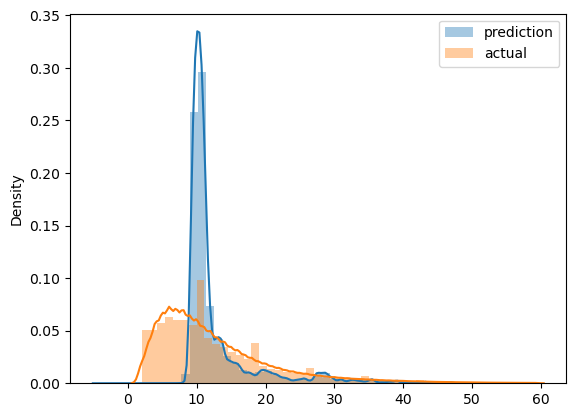

In [137]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [142]:
jan.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_duration'],
      dtype='object')

In [145]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['trip_duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.trip_duration = df.trip_duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [146]:
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [147]:
len(df_train), len(df_val)

(2421440, 2918187)

In [148]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [149]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [150]:
target = 'trip_duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [151]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.530281357573089

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)



9.374921127169834

# Pickle the model

In [153]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

#